# Up Down Market Analysis
- This is a simplifed tool meant for a simple over/under market (will a player perform more or higher of some stat from a previous game)
- Finds highest EV configuration of certain stats (each stat is seperated into a different parlay)
- Useful when there are free square **promos** for risk-free 1->2 pick parlay, achieving extremely high sharpe-ratios in these situations

In [660]:
import nflreadpy as nfl

In [661]:
data = nfl.load_player_stats(True,"week")

In [662]:
data.columns

['player_id',
 'player_name',
 'player_display_name',
 'position',
 'position_group',
 'headshot_url',
 'season',
 'week',
 'season_type',
 'team',
 'opponent_team',
 'completions',
 'attempts',
 'passing_yards',
 'passing_tds',
 'passing_interceptions',
 'sacks_suffered',
 'sack_yards_lost',
 'sack_fumbles',
 'sack_fumbles_lost',
 'passing_air_yards',
 'passing_yards_after_catch',
 'passing_first_downs',
 'passing_epa',
 'passing_cpoe',
 'passing_2pt_conversions',
 'pacr',
 'carries',
 'rushing_yards',
 'rushing_tds',
 'rushing_fumbles',
 'rushing_fumbles_lost',
 'rushing_first_downs',
 'rushing_epa',
 'rushing_2pt_conversions',
 'receptions',
 'targets',
 'receiving_yards',
 'receiving_tds',
 'receiving_fumbles',
 'receiving_fumbles_lost',
 'receiving_air_yards',
 'receiving_yards_after_catch',
 'receiving_first_downs',
 'receiving_epa',
 'receiving_2pt_conversions',
 'racr',
 'target_share',
 'air_yards_share',
 'wopr',
 'special_teams_tds',
 'def_tackles_solo',
 'def_tackles_with_a

In [663]:
import polars as pl

PLAYER_NAME = "A.Rodgers"
VARS = ["passing_yards","rushing_yards","passing_tds"]

var_data = []
for var in VARS:
    var_data.append(data.filter(pl.col("player_name")==PLAYER_NAME)[var])

data_info = data.filter(pl.col("player_name")==PLAYER_NAME)["season"].cast(pl.String)+data.filter(pl.col("player_name")==PLAYER_NAME)["week"].cast(pl.String)

dict_data = {
    "data_info": data_info.cast(pl.Int32)
}

for i,var in enumerate(VARS):
    dict_data["var_"+str(i)] = var_data[i].diff()>0

collected_data = pl.DataFrame(dict_data)[1:]

In [664]:
collected_data.head()

data_info,var_0,var_1,var_2
i32,bool,bool,bool
200515,true,true,false
200517,false,false,false
20064,true,true,false
200611,true,true,false
200710,false,false,false


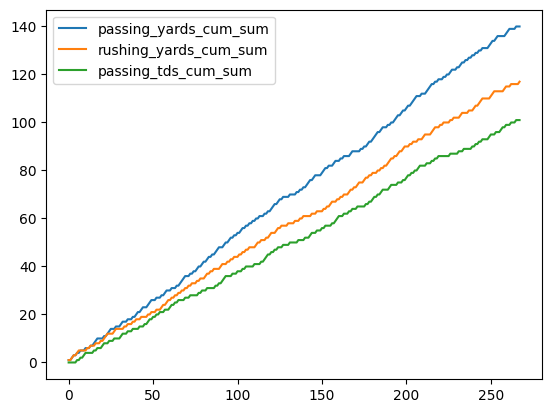

In [665]:
import matplotlib.pyplot as plt

for i,var in enumerate(VARS):
    plt.plot(collected_data["var_"+str(i)].cum_sum(),label = var+"_cum_sum")

plt.legend()


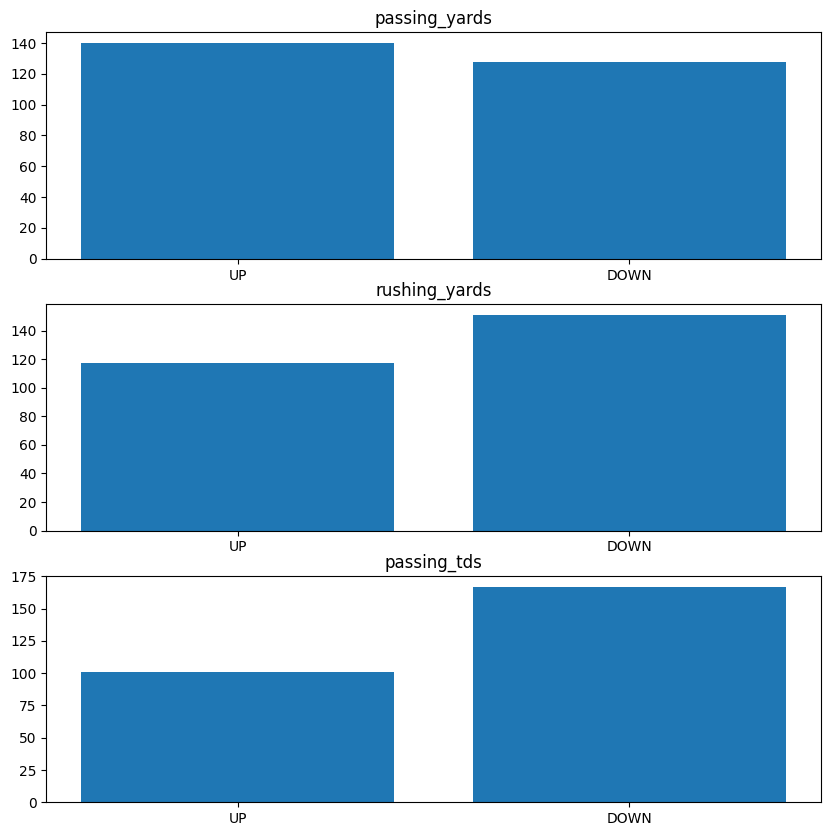

In [666]:
fig,ax = plt.subplots(len(VARS))
fig.set_size_inches(10,10)
for i,var in enumerate(VARS):
    ax[i].bar(x=["UP","DOWN"],height = (collected_data["var_"+str(i)].sum(), len(collected_data["var_"+str(i)])-collected_data["var_"+str(i)].sum()))
    ax[i].set_title(var)

In [667]:
import numpy as np

# Now get the 2^n matrix

def setup_matrix(max_len):
    all_lists = []
    def recurse_setup_matrix(list_val,max_len):
        if(len(list_val)==max_len):
            all_lists.append(np.array(list_val.copy()))
            return
        
        list_val.append(True)
        recurse_setup_matrix(list_val,max_len)

        list_val.pop()
        list_val.append(False)

        recurse_setup_matrix(list_val,max_len)

        list_val.pop()
    
    recurse_setup_matrix([],max_len)
    
    return all_lists

In [668]:
truth_matrix = setup_matrix(len(VARS))
truth_matrix

[array([ True,  True,  True]),
 array([ True,  True, False]),
 array([ True, False,  True]),
 array([ True, False, False]),
 array([False,  True,  True]),
 array([False,  True, False]),
 array([False, False,  True]),
 array([False, False, False])]

In [669]:
MULTIPLIER = 3
PAY_PER_PARLAY_CONFIG= np.array([10,10,10])
ev = []
SLICE1 = -18 # SLICE to seperate backtest

for config_a in truth_matrix:
    total_pay = 0
    for config_b in truth_matrix:
        result_prob = 1

        for i,bool_val in enumerate(config_b):
            # If its false than bool_val (whether or not it was succesful) is flipped because we are taking the over
            result_prob*=(collected_data["var_"+str(i)][:SLICE1] ^ (not ((not config_a[i]) ^ bool_val))).sum()/len(collected_data["var_"+str(i)][:SLICE1])
        
        total_pay += (sum(MULTIPLIER*PAY_PER_PARLAY_CONFIG*config_b) - sum(PAY_PER_PARLAY_CONFIG))*result_prob
    
    ev.append(total_pay)

In [670]:
print(ev)

[np.float64(10.32), np.float64(17.759999999999998), np.float64(13.92), np.float64(21.36), np.float64(8.639999999999999), np.float64(16.08), np.float64(12.239999999999998), np.float64(19.68)]


In [671]:
print("EV MAX: "+str(max(ev)))

EV MAX: 21.36


In [672]:
print("OVER UNDER CONFIG: "+str(truth_matrix[ev.index(max(ev))]))

OVER UNDER CONFIG: [ True False False]


# Backtesting

In [673]:
SET_TRUTH_MATRIX = [True, False, False]
INITIAL_MONEY = 100

collected_data_slice = collected_data[SLICE1:]
bankroll_pay_per_config_norm = PAY_PER_PARLAY_CONFIG/np.linalg.norm(PAY_PER_PARLAY_CONFIG)

money = [INITIAL_MONEY]
p_returns = []
for ind in range(len(collected_data_slice)):
    curr_money = money[-1]
    pay_per = bankroll_pay_per_config_norm*money[-1]/5 # Bankroll managment only bet 20% on a set of parlays per week

    for i in range(len(VARS)):
        if collected_data_slice["var_"+str(i)][ind] == SET_TRUTH_MATRIX[i]:
            curr_money+=MULTIPLIER*pay_per[i]-pay_per[i]
        else:
            curr_money-=pay_per[i]
        
    p_returns.append((curr_money-money[-1])/money[-1])
    money.append(curr_money)

print(money)

[100, np.float64(100.0), np.float64(134.64101615137753), np.float64(134.64101615137753), np.float64(181.28203230275506), np.float64(306.8779084818407), np.float64(413.1835343240447), np.float64(413.18353432404473), np.float64(413.1835343240448), np.float64(413.18353432404484), np.float64(413.1835343240449), np.float64(699.4454840440949), np.float64(1184.0355302396865), np.float64(773.8735909713077), np.float64(1041.9512666109238), np.float64(1402.893773167097), np.float64(1888.8704317165812), np.float64(2543.194343046117), np.float64(2543.194343046117)]


Text(0.5, 0.98, 'One Season Backtest')

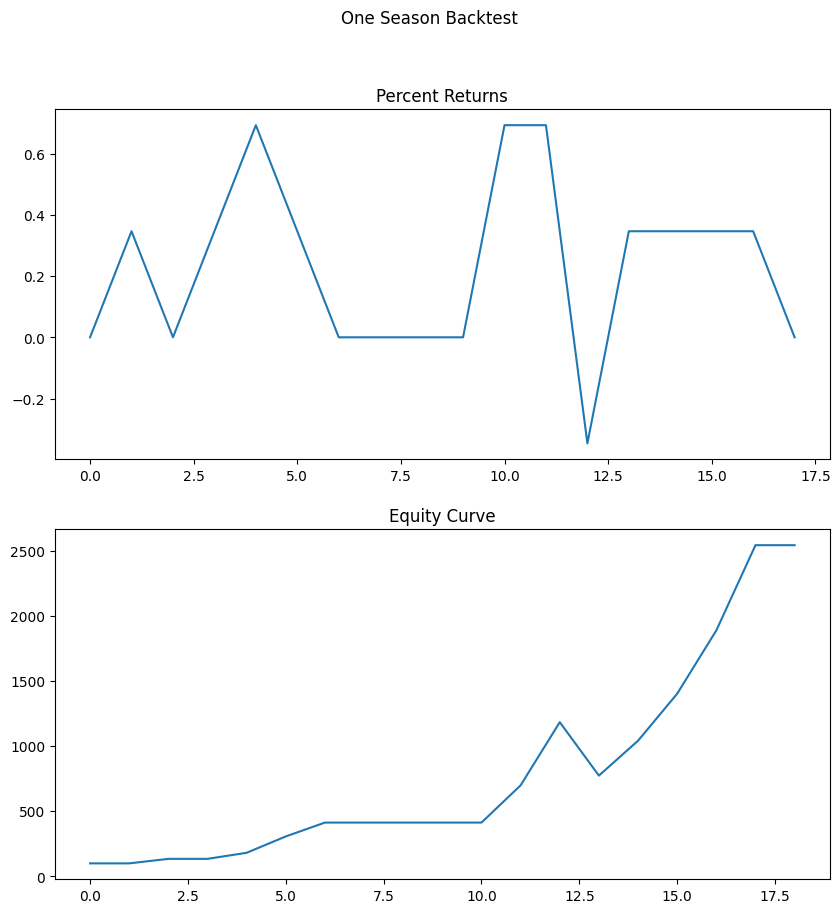

In [658]:
fig,ax = plt.subplots(2)
fig.set_size_inches(10,10)
ax[0].plot(p_returns)
ax[0].set_title("Percent Returns")
ax[1].plot(money)
ax[1].set_title("Equity Curve")
fig.suptitle("One Season Backtest")

## Calculate Metrics

In [659]:
import math

sharpe_ratio_std = np.std(p_returns)
risk_free_rate = 0.05/52
return_f = np.mean(p_returns)

print("Sharpe ratio: "+str((return_f-risk_free_rate)/sharpe_ratio_std * math.sqrt(52)))

Sharpe ratio: 5.863326060659626
